In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import pickle

import matplotlib.pyplot as plt
plt.ion()

In [2]:
faces_data_train = []
faces_data_val = []

In [3]:
!unzip /content/drive/MyDrive/GAF_3.0.zip

Archive:  /content/drive/MyDrive/GAF_3.0.zip
 extracting: Train/Negative.zip      
 extracting: Train/Neutral.zip       
 extracting: Train/Positive.zip      
 extracting: Validation/Negative.zip  
 extracting: Validation/Neutral.zip  
 extracting: Validation/Positive.zip  
 extracting: ReadMe.txt              
 extracting: Test_Images.zip         


In [6]:
!unzip /content/Train/Positive.zip

Archive:  /content/Train/Positive.zip
  inflating: Positive/pos_1.jpg      
  inflating: Positive/pos_10.jpg     
  inflating: Positive/pos_100.jpg    
  inflating: Positive/pos_1000.jpg   
  inflating: Positive/pos_1001.jpg   
  inflating: Positive/pos_1002.jpg   
  inflating: Positive/pos_1003.jpg   
  inflating: Positive/pos_1004.jpg   
  inflating: Positive/pos_1005.jpg   
  inflating: Positive/pos_1006.jpg   
  inflating: Positive/pos_1007.jpg   
  inflating: Positive/pos_1008.jpg   
  inflating: Positive/pos_1009.jpg   
  inflating: Positive/pos_101.jpg    
  inflating: Positive/pos_1010.jpg   
  inflating: Positive/pos_1011.jpg   
  inflating: Positive/pos_1012.jpg   
  inflating: Positive/pos_1013.jpg   
  inflating: Positive/pos_1014.jpg   
  inflating: Positive/pos_1015.jpg   
  inflating: Positive/pos_1016.jpg   
  inflating: Positive/pos_1017.jpg   
  inflating: Positive/pos_1018.jpg   
  inflating: Positive/pos_1019.jpg   
  inflating: Positive/pos_102.jpg    
  inflating:

In [5]:
!unzip /content/Train/Neutral.zip

Archive:  /content/Train/Neutral.zip
  inflating: Neutral/neu_1.jpg       
  inflating: Neutral/neu_10.jpg      
  inflating: Neutral/neu_100.jpg     
 extracting: Neutral/neu_1000.jpg    
  inflating: Neutral/neu_1001.jpg    
  inflating: Neutral/neu_1002.jpg    
  inflating: Neutral/neu_1003.jpg    
  inflating: Neutral/neu_1004.jpg    
  inflating: Neutral/neu_1005.jpg    
  inflating: Neutral/neu_1006.jpg    
  inflating: Neutral/neu_1007.jpg    
  inflating: Neutral/neu_1008.jpg    
  inflating: Neutral/neu_1009.jpg    
  inflating: Neutral/neu_101.jpg     
  inflating: Neutral/neu_1010.jpg    
  inflating: Neutral/neu_1011.jpg    
  inflating: Neutral/neu_1012.jpg    
  inflating: Neutral/neu_1013.jpg    
  inflating: Neutral/neu_1014.jpg    
  inflating: Neutral/neu_1015.jpg    
  inflating: Neutral/neu_1016.jpg    
  inflating: Neutral/neu_1017.jpg    
  inflating: Neutral/neu_1018.jpg    
  inflating: Neutral/neu_1019.jpg    
  inflating: Neutral/neu_102.jpg     
  inflating: 

In [4]:
!unzip /content/Train/Negative.zip

Archive:  /content/Train/Negative.zip
  inflating: Negative/neg_1.jpg      
  inflating: Negative/neg_10.jpg     
  inflating: Negative/neg_100.jpg    
  inflating: Negative/neg_1000.jpg   
  inflating: Negative/neg_1001.jpg   
  inflating: Negative/neg_1002.jpg   
  inflating: Negative/neg_1003.jpg   
  inflating: Negative/neg_1004.jpg   
  inflating: Negative/neg_1005.jpg   
  inflating: Negative/neg_1006.jpg   
  inflating: Negative/neg_1007.jpg   
  inflating: Negative/neg_1008.jpg   
  inflating: Negative/neg_1009.jpg   
  inflating: Negative/neg_101.jpg    
  inflating: Negative/neg_1010.jpg   
  inflating: Negative/neg_1011.jpg   
  inflating: Negative/neg_1012.jpg   
  inflating: Negative/neg_1013.jpg   
  inflating: Negative/neg_1014.jpg   
  inflating: Negative/neg_1015.jpg   
  inflating: Negative/neg_1016.jpg   
  inflating: Negative/neg_1017.jpg   
  inflating: Negative/neg_1018.jpg   
  inflating: Negative/neg_1019.jpg   
  inflating: Negative/neg_102.jpg    
  inflating:

In [7]:
neg_train = sorted(os.listdir('/content/'+'Negative/'))#/content/Negative
neu_train = sorted(os.listdir('/content/'+'Neutral/'))
pos_train = sorted(os.listdir('/content/'+'Positive/'))

train_filelist = neg_train + neu_train + pos_train

In [8]:
!unzip /content/drive/MyDrive/mtcnn.zip

Archive:  /content/drive/MyDrive/mtcnn.zip
 extracting: mtcnn/AlignedCroppedImages.zip  
 extracting: mtcnn/CroppedFaces.zip  
  inflating: mtcnn/FaceCoordinates.rar  
 extracting: mtcnn/FaceFeatures.zip  
  inflating: mtcnn/test_list         
  inflating: mtcnn/train_annotations.npz  
  inflating: mtcnn/val_annotations.npz  
  inflating: mtcnn/val_list          


In [9]:
val_filelist = []
test_filelist = []

with open('/content/mtcnn/val_list', 'rb') as fp: #/content/mtcnn/val_list
    val_filelist = pickle.load(fp)

with open('/content/mtcnn/test_list', 'rb') as fp: #/content/mtcnn/test_list
    test_filelist = pickle.load(fp)

for i in train_filelist:
    if i[0] != 'p' and i[0] != 'n':
        train_filelist.remove(i)
        
for i in val_filelist:
    if i[0] != 'p' and i[0] != 'n':
        val_filelist.remove(i)

In [10]:
dataset_sizes = [len(train_filelist), len(val_filelist), len(test_filelist)]
print(dataset_sizes)

[9815, 3341, 1000]


In [11]:
!unzip /content/mtcnn/FaceFeatures.zip

Streaming output truncated to the last 5000 lines.
  inflating: FaceFeatures/train/Positive/pos_41.npz  
  inflating: FaceFeatures/train/Positive/pos_410.npz  
  inflating: FaceFeatures/train/Positive/pos_411.npz  
  inflating: FaceFeatures/train/Positive/pos_412.npz  
  inflating: FaceFeatures/train/Positive/pos_413.npz  
  inflating: FaceFeatures/train/Positive/pos_414.npz  
  inflating: FaceFeatures/train/Positive/pos_415.npz  
  inflating: FaceFeatures/train/Positive/pos_416.npz  
  inflating: FaceFeatures/train/Positive/pos_417.npz  
  inflating: FaceFeatures/train/Positive/pos_418.npz  
  inflating: FaceFeatures/train/Positive/pos_419.npz  
  inflating: FaceFeatures/train/Positive/pos_42.npz  
  inflating: FaceFeatures/train/Positive/pos_420.npz  
  inflating: FaceFeatures/train/Positive/pos_421.npz  
  inflating: FaceFeatures/train/Positive/pos_422.npz  
  inflating: FaceFeatures/train/Positive/pos_423.npz  
  inflating: FaceFeatures/train/Positive/pos_424.npz  
  inflating: Fac

## **Make List of Number of Faces in Train Image**

In [22]:
for i in range(len(train_filelist)):
    
    filename = train_filelist[i].split('.')[0]
    labeldict = {'neg':'Negative',
                 'neu':'Neutral',
                 'pos':'Positive',
                 'Negative': 0,
                 'Neutral': 1,
                 'Positive':2}

    labelname = labeldict[filename.split('_')[0]]
    
    features = np.load('/content/FaceFeatures/train/'+labelname+'/'+filename+'.npz')['a'] #/content/FaceFeatures/train
    faces_data_train.append(features.shape[0])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

FileNotFoundError: ignored

In [13]:
print(len(faces_data_train))

1712


## **Make List of Number of Faces in Val Images**

In [14]:
for i in range(len(val_filelist)):
    
    filename = val_filelist[i].split('.')[0]
    labeldict = {'neg':'Negative',
                 'neu':'Neutral',
                 'pos':'Positive',
                 'Negative': 0,
                 'Neutral': 1,
                 'Positive':2}

    labelname = labeldict[filename.split('_')[0]]
    
    features = np.load('/content/FaceFeatures/val/'+labelname+'/'+filename+'.npz')['a'] #/content/FaceFeatures/val
    faces_data_val.append(features.shape[0])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
print(len(faces_data_val))

3341


## **Calculating Number of Faces Covering 80% of Data**

In [16]:
faces_data_train.sort()

In [17]:
faces_data_val.sort()

In [18]:
faces_data_total = faces_data_train + faces_data_val

In [19]:
faces_data_total.sort()

In [20]:
perdata = .8

print(faces_data_total[int(perdata*len(faces_data_total))])
print(faces_data_train[int(perdata*len(faces_data_train))])
print(faces_data_val[int(perdata*len(faces_data_val))])

13
15
11


## **Visualization**

AttributeError: ignored

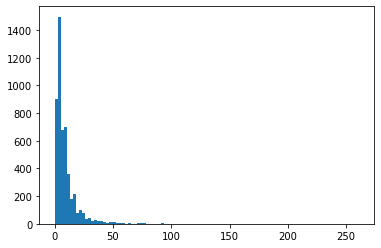

In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(faces_data_total, normed=True, bins=100)
plt.axis([0, 50, 0, 0.06]) 
plt.ylabel('Probability');